In [1]:
from typing import List, Optional, Callable, Iterable
from itertools import islice
import json

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [3]:
import torch
import torch.nn as nn

In [4]:
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.modules.distribution_output import StudentTOutput
from gluonts.model.forecast_generator import DistributionForecastGenerator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.transform import (AddObservedValuesIndicator, InstanceSplitter, ExpectedNumInstanceSampler, 
                               TestSplitSampler)

In [5]:
import pytorch_lightning as pl

In [178]:
dataset = get_dataset("eletriciy")

AssertionError: eletriciy is not present, please choose one from odict_keys(['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']).

In [168]:
def mean_abs_scaling(context, min_scale=1e-5):
    return context.abs().mean(1).clamp(min_scale, None).unsqueeze(1)

In [169]:
class FeedForwardNetwork(nn.Module):
    def __init__(
        self,
        encoder_dim: int,
        freq: str,
        prediction_length: int,
        local_context_length: int,
        hidden_dimensions: List[int],
        encoder_path: Optional[str]=None,
        distr_output = StudentTOutput(),
        batch_norm: bool=False,
        scaling: Callable=mean_abs_scaling,
    ) -> None:
        super().__init__()

        assert prediction_length > 0
        assert len(hidden_dimensions) > 0
        
        if encoder_path is not None:
            self.encoder = torch.jit.load(encoder_path)
        else:
            self.encoder = None
        
        self.encoder_dim = encoder_dim
        self.freq = freq
        self.prediction_length = prediction_length
        self.local_context_length = local_context_length
        self.hidden_dimensions = hidden_dimensions
        self.distr_output = distr_output
        self.batch_norm = batch_norm
        self.scaling = scaling

        dimensions = [encoder_dim+local_context_length] + hidden_dimensions[:-1]

        modules = []
        for in_size, out_size in zip(dimensions[:-1], dimensions[1:]):
            modules += [self.__make_lin(in_size, out_size), nn.ReLU()]
            if batch_norm:
                modules.append(nn.BatchNorm1d(out_size))
        modules.append(self.__make_lin(dimensions[-1], prediction_length * hidden_dimensions[-1]))

        self.nn = nn.Sequential(*modules)
        self.args_proj = self.distr_output.get_args_proj(hidden_dimensions[-1])

    @staticmethod
    def __make_lin(dim_in, dim_out):
        lin = nn.Linear(dim_in, dim_out)
        torch.nn.init.uniform_(lin.weight, -0.07, 0.07)
        torch.nn.init.zeros_(lin.bias)
        return lin

    def forward(self, context):
        scale = self.scaling(context)
        scaled_context = context / scale
            
        if self.encoder is not None:
            with torch.no_grad():
                encoding = self.encoder(context.unsqueeze(1))
        
            local_context = scaled_context[...,-self.local_context_length:]
            nn_out = self.nn(torch.cat((encoding, local_context), dim=-1))
        else:
            # use a slighly bigger context of size encoder_dim
            # Identity encoding model
            local_context = scaled_context[...,-(self.local_context_length+self.encoder_dim):]
            nn_out = self.nn(local_context)
        
        nn_out_reshaped = nn_out.reshape(-1, self.prediction_length, self.hidden_dimensions[-1])
        distr_args = self.args_proj(nn_out_reshaped)
        return distr_args, torch.zeros_like(scale), scale

    def get_predictor(self, input_transform, batch_size=32, device=None):
        return PyTorchPredictor(
            prediction_length=self.prediction_length,
            freq=self.freq,
            input_names=["past_target"],
            prediction_net=self,
            batch_size=batch_size,
            input_transform=input_transform,
            forecast_generator=DistributionForecastGenerator(self.distr_output),
            device=None,
        )

In [170]:
class LightningFeedForwardNetwork(FeedForwardNetwork, pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        context = batch["past_target"]
        target = batch["future_target"]

        assert target.shape[-1] == self.prediction_length

        distr_args, loc, scale = self(context)
        
        distr = self.distr_output.distribution(distr_args, loc, scale)
        loss = -distr.log_prob(target)

        return loss.mean()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [171]:
freq = dataset.metadata.freq
context_length = 5 * 7 * dataset.metadata.prediction_length
local_context_length =  dataset.metadata.prediction_length  
prediction_length = dataset.metadata.prediction_length
hidden_dimensions = [96, 48]

In [172]:
net = LightningFeedForwardNetwork(
    encoder_dim=128,
    encoder_path="./elec_barlow_twins.pt",
    freq=freq,
    prediction_length=prediction_length,
    local_context_length=local_context_length,
    hidden_dimensions=hidden_dimensions,
    distr_output=StudentTOutput(),
)

In [173]:
mask_unobserved = AddObservedValuesIndicator(
    target_field=FieldName.TARGET,
    output_field=FieldName.OBSERVED_VALUES,
)

In [174]:
training_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=ExpectedNumInstanceSampler(
        num_instances=1,
        min_future=prediction_length,
    ),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [175]:
batch_size = 32
num_batches_per_epoch = 50

In [176]:
data_loader = TrainDataLoader(
    # We cache the dataset, to make training faster
    Cached(dataset.train),
    batch_size=batch_size,
    stack_fn=batchify,
    transform=mask_unobserved + training_splitter,
    num_batches_per_epoch=num_batches_per_epoch,
)

In [177]:
trainer = pl.Trainer(max_epochs=10, gpus=-1 if torch.cuda.is_available() else None)
trainer.fit(net, train_dataloaders=data_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                  | Params
----------------------------------------------------
0 | encoder   | RecursiveScriptModule | 88.9 K
1 | nn        | Sequential            | 145 K 
2 | args_proj | PtArgProj             | 147   
----------------------------------------------------
234 K     Trainable params
0         Non-trainable params
234 K     Total params
0.938     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/dataset/common.py:328: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated

ValueError: expected sequence of length 1913 at dim 2 (got 1912)

In [162]:
prediction_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=TestSplitSampler(),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [163]:
predictor_pytorch = net.get_predictor(mask_unobserved + prediction_splitter)

In [164]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, predictor=predictor_pytorch
)

forecasts_pytorch = list(f.to_sample_forecast() for f in forecast_it)
tss_pytorch = list(ts_it)

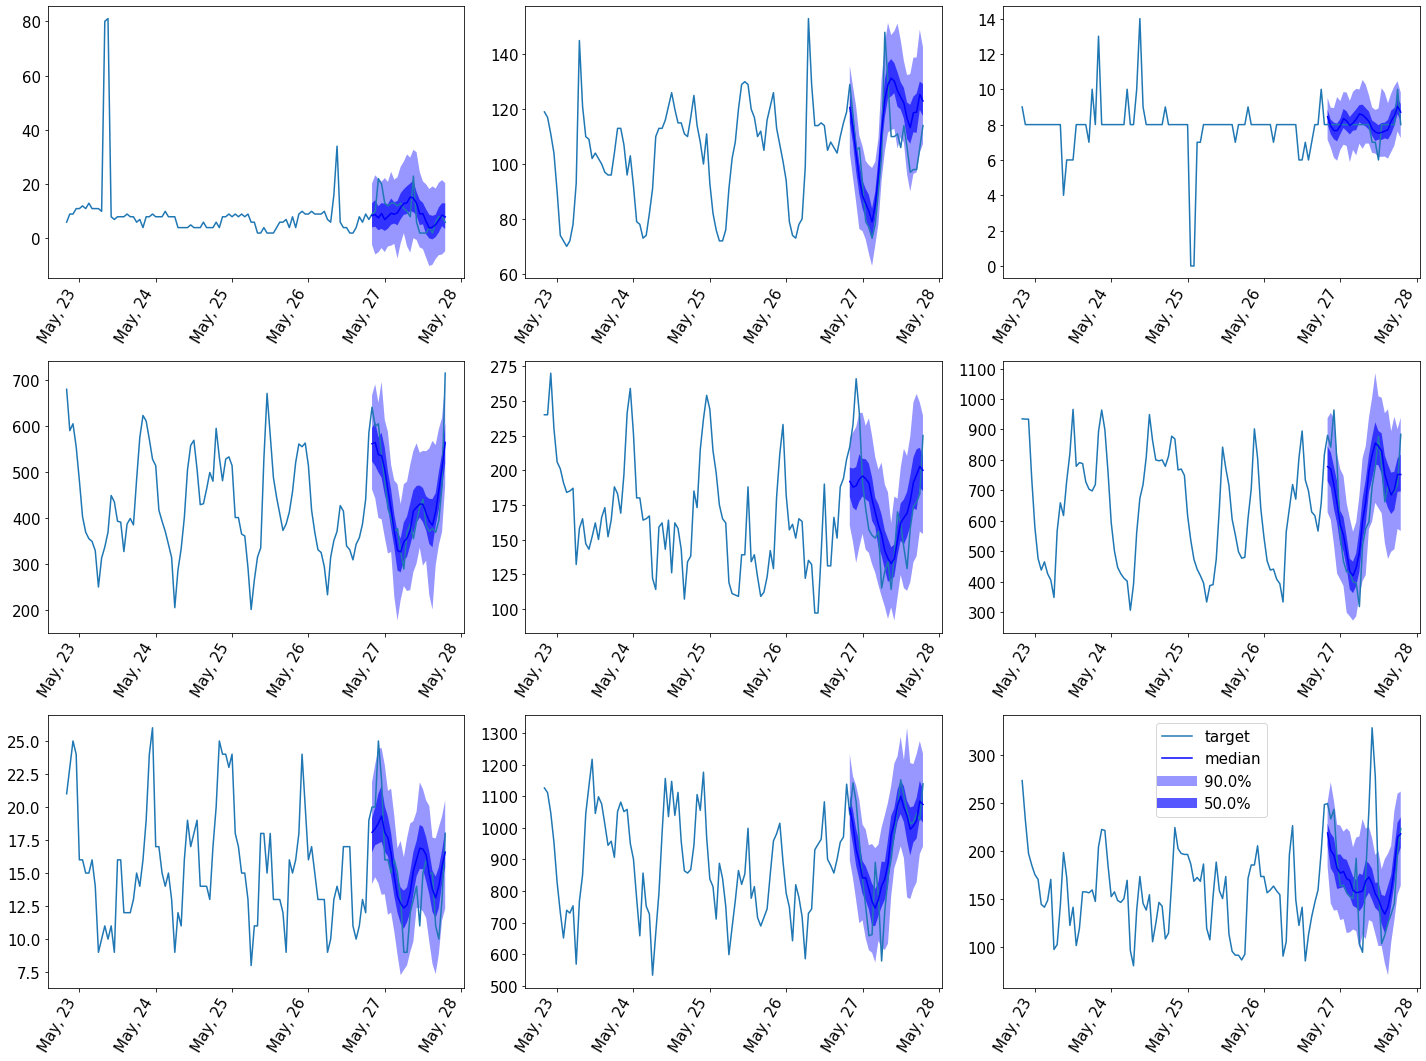

In [165]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_pytorch, tss_pytorch)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-5 * prediction_length:], label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [166]:
evaluator = Evaluator()
metrics_pytorch, _ = evaluator(iter(tss_pytorch), iter(forecasts_pytorch), num_series=len(dataset.test))
print(json.dumps(metrics_pytorch, indent=4))


Running evaluation: 100%|█████████████████| 2247/2247 [00:00<00:00, 3247.91it/s]/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/.env/pytorch/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = foreca

{
    "MSE": 2528121.3487035073,
    "abs_error": 12233316.403560642,
    "abs_target_sum": 128632956.0,
    "abs_target_mean": 2385.272140631954,
    "seasonal_error": 189.49338196116761,
    "MASE": 1.1375018907923597,
    "MAPE": 0.18052326396298338,
    "sMAPE": 0.1529135614602613,
    "MSIS": 8.98677700968042,
    "QuantileLoss[0.1]": 6054928.316977579,
    "Coverage[0.1]": 0.1242953567719923,
    "QuantileLoss[0.2]": 9154539.1553004,
    "Coverage[0.2]": 0.24338006230529596,
    "QuantileLoss[0.3]": 10958867.784776973,
    "Coverage[0.3]": 0.3538421599169263,
    "QuantileLoss[0.4]": 11918405.252889747,
    "Coverage[0.4]": 0.4659731493843643,
    "QuantileLoss[0.5]": 12233316.4930911,
    "Coverage[0.5]": 0.5713729417000445,
    "QuantileLoss[0.6]": 12039510.628671972,
    "Coverage[0.6]": 0.6637924640261089,
    "QuantileLoss[0.7]": 11213634.0895126,
    "Coverage[0.7]": 0.7490728378578846,
    "QuantileLoss[0.8]": 9518030.496744145,
    "Coverage[0.8]": 0.8267133956386293,
   

/home/kashif/.env/pytorch/lib/python3.8/site-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)
